In [155]:
import os
from pathlib import Path
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import tifffile as tiff
import torchvision.models as models
import wandb
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

# ===== PATHS =====
HS_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\train\HS"
TEST_HS_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\val\HS"
CHECKPOINT_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints"
CKPT_PATH = os.path.join(CHECKPOINT_DIR, "best_hs125_resnet18_topK.pth")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ===== DATA SETTINGS =====
TARGET_BANDS = 125
TARGET_HW = (64, 64)       # Resizing to 64x64 for consistency

# ===== SPLIT =====
VAL_RATIO = 0.2
SEED = 42

# ===== TRAIN =====
EPOCHS = 10
BATCH_SIZE = 32
LR = 1e-4
WD = 0.1
NUM_WORKERS = 0


In [156]:
# ===== REPRODUCIBILITY =====
import random

def set_seed(seed=42):
    """Set seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    
    # Make PyTorch deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set environment variable for CUDA
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print(f"✓ Random seed set to {seed} for reproducibility")

# Apply seed
set_seed(SEED)

✓ Random seed set to 42 for reproducibility


In [157]:
prefixes = sorted({
    fn.split("_")[0]
    for fn in os.listdir(HS_DIR)
    if fn.endswith(".tif")
})

print("MS classes:", prefixes)
print("NUM_CLASSES =", len(prefixes))

MS classes: ['Health', 'Other', 'Rust']
NUM_CLASSES = 3


In [158]:
from tqdm import tqdm

# ===============================================================
# Robust CHW conversion  (dùng chung cho stats / train / test)
# ===============================================================
def ensure_chw(arr: np.ndarray, expected_bands: int) -> np.ndarray:
    """
    Đảm bảo array có dạng (C, H, W).
    Quy tắc:
      - 2-D  -> (1, H, W)
      - 3-D  -> so sánh shape[0] vs shape[2]:
          * Nếu shape[2] == expected_bands            -> HWC, transpose
          * Nếu shape[0] == expected_bands            -> đã CHW
          * Nếu cả 2 != expected_bands                -> chọn dim nhỏ nhất làm C
    """
    if arr.ndim == 2:
        return arr[None, :, :]

    if arr.ndim != 3:
        raise ValueError(f"Expected 2-D or 3-D array, got {arr.ndim}-D")

    d0, d1, d2 = arr.shape

    # Trường hợp rõ ràng
    if d2 == expected_bands and d0 != expected_bands:
        return np.transpose(arr, (2, 0, 1))         # HWC -> CHW
    if d0 == expected_bands and d2 != expected_bands:
        return arr                                    # CHW rồi

    # Cả 2 chiều == expected_bands (vuông): ưu tiên CHW (dim-0 = C)
    if d0 == expected_bands and d2 == expected_bands:
        return arr  # giữ nguyên, coi dim-0 là C

    # Không chiều nào == expected_bands: chọn dim nhỏ nhất làm C
    dims = [d0, d1, d2]
    c_axis = int(np.argmin(dims))
    if c_axis == 2:
        return np.transpose(arr, (2, 0, 1))
    elif c_axis == 1:
        return np.transpose(arr, (1, 0, 2))
    else:
        return arr


def fix_bands(arr: np.ndarray, target_bands: int) -> np.ndarray:
    """Cắt hoặc pad bands. Pad bằng mean spatial (tránh tín hiệu giả)."""
    c = arr.shape[0]
    if c > target_bands:
        return arr[:target_bands]
    if c < target_bands:
        pad = np.repeat(
            arr.mean(axis=0, keepdims=True),    # mean spatial
            target_bands - c, axis=0
        ).astype(arr.dtype)
        return np.concatenate([arr, pad], axis=0)
    return arr


def clip_per_band(x: torch.Tensor, ql=0.01, qh=0.99) -> torch.Tensor:
    """Clip mỗi band theo quantile q1/q99. Input/output: (C, H, W)."""
    C = x.shape[0]
    flat = x.view(C, -1)
    lo = torch.quantile(flat, ql, dim=1).view(-1, 1, 1)
    hi = torch.quantile(flat, qh, dim=1).view(-1, 1, 1)
    return torch.clamp(x, lo, hi)


# ===============================================================
# Compute global stats  (match pipeline: ensure_chw → fix_bands
#                         → resize → clip_per_band → accumulate)
# ===============================================================
@torch.no_grad()
def compute_global_stats_matched(
    img_dir,
    file_list,
    target_bands=125,
    target_hw=(64, 64),
    clip_q=(0.01, 0.99),
    eps=1e-8,
    max_files=None,
):
    ql, qh = clip_q
    sum_c   = torch.zeros(target_bands, dtype=torch.float64)
    sumsq_c = torch.zeros(target_bands, dtype=torch.float64)
    count   = 0

    files = file_list if max_files is None else file_list[:max_files]

    for fname in tqdm(files, desc="Computing stats"):
        path = os.path.join(img_dir, fname)
        arr = tiff.imread(path).astype(np.float32)

        arr = ensure_chw(arr, target_bands)
        arr = fix_bands(arr, target_bands)

        x = torch.from_numpy(arr)  # (C, H, W)

        # Resize
        if x.shape[1:] != target_hw:
            x = F.interpolate(x.unsqueeze(0), size=target_hw,
                              mode="bilinear", align_corners=False).squeeze(0)

        # Clip per-band
        x = clip_per_band(x, ql, qh)

        # Accumulate
        sum_c   += x.sum(dim=(1, 2), dtype=torch.float64)
        sumsq_c += (x * x).sum(dim=(1, 2), dtype=torch.float64)
        count   += x.shape[1] * x.shape[2]

    mean = (sum_c / (count + eps)).to(torch.float32)
    var  = (sumsq_c / (count + eps) - mean.double()**2).clamp_min(0.0).to(torch.float32)
    std  = torch.sqrt(var + eps)

    return mean.cpu().numpy(), std.cpu().numpy()


def label_from_filename(fname: str) -> str:
    return os.path.basename(fname).split("_")[0]


In [159]:
import numpy as np
import torch
import torch.nn.functional as F
import tifffile as tiff

TARGET_BANDS = 125

def to_chw(arr: np.ndarray, expected_bands: int = 125) -> np.ndarray:
    """
    Đưa ảnh về dạng (C,H,W) từ các dạng phổ biến:
    - (H,W,C)
    - (C,H,W)
    - (H,W) (hiếm)
    """
    if arr.ndim == 2:
        # (H,W) -> (1,H,W)
        return arr[None, :, :]

    if arr.ndim != 3:
        raise ValueError(f"Unsupported ndim={arr.ndim}, shape={arr.shape}")

    a, b, c = arr.shape

    # Nếu đang HWC và C khớp expected hoặc rất gần expected
    if c == expected_bands or c == expected_bands + 1 or c == expected_bands - 1:
        return np.transpose(arr, (2, 0, 1))  # HWC -> CHW

    # Nếu đang CHW và C khớp expected hoặc gần expected
    if a == expected_bands or a == expected_bands + 1 or a == expected_bands - 1:
        return arr  # đã CHW

    # Heuristic: chọn chiều nhỏ nhất làm channel (thường C nhỏ hơn H,W nếu ảnh lớn)
    # Nhưng với case 32x32x125 thì C=125 lại lớn hơn 32 -> heuristic này không dùng được.
    # Nên ta ưu tiên nếu có chiều đúng/near expected ở trên; nếu không có thì fallback:
    # Nếu một chiều <= 256 và hai chiều còn lại bằng nhau (ví dụ 32x32x125), khả năng C là chiều còn lại.
    if a == b and c <= 256:
        # arr là (H,W,C)
        return np.transpose(arr, (2, 0, 1))
    if b == c and a <= 256:
        # arr là (C,H,W) nhưng H=W?
        return arr
    if a == c and b <= 256:
        # hiếm, nhưng vẫn xử lý
        return np.transpose(arr, (1, 0, 2))  # -> (H,C,W) rồi sẽ lỗi; để an toàn, raise
    # Nếu vẫn mơ hồ:
    raise ValueError(f"Ambiguous shape {arr.shape}: can't infer channel dim safely.")

def fix_bands_chw(x_chw: np.ndarray, target_bands: int = 125, pad_mode: str = "mean") -> np.ndarray:
    """
    x_chw: (C,H,W) -> trả về (125,H,W)
    - C > 125: cắt
    - C == 126: cắt bỏ band cuối (thường là band thừa)
    - C < 125: pad thêm band
    """
    C, H, W = x_chw.shape

    if C == target_bands:
        return x_chw

    if C > target_bands:
        return x_chw[:target_bands, :, :]

    # C < target_bands: pad
    if pad_mode == "mean":
        band_mean = x_chw.mean(axis=(1, 2), keepdims=True)  # (C,1,1)
        pad_C = target_bands - C
        # lặp mean của toàn ảnh theo từng band cuối cùng (hoặc dùng global mean chung)
        # Cách đơn giản: dùng mean chung của toàn tensor
        global_mean = x_chw.mean(keepdims=True)  # (1,1,1)
        pad = np.repeat(global_mean, pad_C, axis=0)  # (pad_C,1,1) -> sẽ broadcast sai
        # sửa cho đúng shape (pad_C,H,W)
        pad = np.repeat(global_mean, pad_C, axis=0)
        pad = np.repeat(pad, H, axis=1)
        pad = np.repeat(pad, W, axis=2)
        return np.concatenate([x_chw, pad], axis=0)

    elif pad_mode == "zero":
        pad_C = target_bands - C
        pad = np.zeros((pad_C, H, W), dtype=x_chw.dtype)
        return np.concatenate([x_chw, pad], axis=0)

    else:
        raise ValueError("pad_mode must be 'mean' or 'zero'")

def load_hs_as_125(path: str, target_hw=(64, 64), target_bands: int = 125) -> torch.Tensor:
    """
    Đọc tif -> CHW -> fix bands -> resize -> tensor float32
    """
    arr = tiff.imread(path).astype(np.float32)

    x = to_chw(arr, expected_bands=target_bands)          # (C,H,W)
    x = fix_bands_chw(x, target_bands=target_bands)       # (125,H,W)

    x = torch.from_numpy(x)                               # (C,H,W)
    x = x.unsqueeze(0)                                    # (1,C,H,W)
    x = F.interpolate(x, size=target_hw, mode="bilinear", align_corners=False)
    x = x.squeeze(0)                                      # (C,H,W)
    return x


In [160]:
class HSDataset(Dataset):
    """
    Hyperspectral Dataset with Global Z-score Normalization.
    Pipeline: load → ensure_chw → fix_bands → resize → clip_per_band → z-score → augment
    """
    def __init__(self, img_dir, file_list=None, target_bands=125, target_hw=(64, 64),
                 augment=False, mean=None, std=None):
        self.img_dir = img_dir
        self.target_bands = target_bands
        self.target_hw = target_hw
        self.augment = augment

        # Normalization stats (per-band)
        self.mean = (torch.tensor(mean).view(target_bands, 1, 1).float()
                     if mean is not None else torch.zeros(target_bands, 1, 1))
        self.std  = (torch.tensor(std).view(target_bands, 1, 1).float()
                     if std is not None else torch.ones(target_bands, 1, 1))

        if file_list is not None:
            self.files = file_list
        else:
            self.files = sorted([f for f in os.listdir(img_dir)
                                 if f.lower().endswith((".tif", ".tiff"))])

        # Label mapping
        labels = sorted({label_from_filename(f) for f in self.files})
        self.class_to_idx = {c: i for i, c in enumerate(labels)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}
        self.y = [self.class_to_idx[label_from_filename(f)] for f in self.files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        label = self.y[idx]
        path  = os.path.join(self.img_dir, fname)

        # 1. Load
        arr = tiff.imread(path).astype(np.float32)

        # 2. Ensure CHW (ƯU TIÊN case HWC = (32,32,125/126))
        if arr.ndim != 3:
            raise ValueError(f"Invalid shape {arr.shape} | file={fname}")

        # Nếu là HWC (rất phổ biến với HS)
        if arr.shape[2] in (125, 126):
            arr = np.transpose(arr, (2, 0, 1))  # HWC -> CHW

        # Nếu là CHW
        elif arr.shape[0] in (125, 126):
            pass  # đã đúng CHW

        else:
            raise ValueError(f"Cannot infer channel dim: {arr.shape} | file={fname}")

        # 3. Fix bands → LUÔN về 125
        C, H, W = arr.shape

        if C == 126:
            arr = arr[:125]          # cắt band thừa
        elif C == 125:
            pass                     # ok
        elif C < 125:
            # pad bằng spatial mean (rất hiếm với dataset này)
            pad_c = 125 - C
            mean_band = arr.mean(axis=(1, 2), keepdims=True).mean(axis=0)
            pad = np.repeat(mean_band, pad_c, axis=0)
            arr = np.concatenate([arr, pad], axis=0)
        else:
            arr = arr[:125]

        x = torch.from_numpy(arr)    # (125,H,W)
        assert x.shape[0] == 125, f"Band mismatch {x.shape} | file={fname}"

        # 4. Resize
        if x.shape[1:] != self.target_hw:
            x = F.interpolate(
                x.unsqueeze(0),
                size=self.target_hw,
                mode="bilinear",
                align_corners=False
            ).squeeze(0)

        # 5. Clip per-band (LUÔN chạy)
        x = clip_per_band(x, 0.01, 0.99)

        # 6. Z-score normalize
        x = (x - self.mean) / (self.std + 1e-8)

        # 7. Augmentation (spatial only – OK cho HS)
        if self.augment:
            if torch.rand(1) > 0.5:
                x = torch.flip(x, dims=[2])  # horizontal
            if torch.rand(1) > 0.5:
                x = torch.flip(x, dims=[1])  # vertical
            k = torch.randint(0, 4, (1,)).item()
            x = torch.rot90(x, k, dims=[1, 2])

        return x, label


In [161]:
import os
from collections import Counter

HS_DIR = r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\HS"  # sửa đúng path của bạn

# Nếu bạn chưa có mean/std thì cho None để chỉ check shape
ds = HSDataset(
    img_dir=HS_DIR,
    target_bands=125,
    target_hw=(64, 64),
    augment=False,
    mean=None,   # hoặc mean_stats
    std=None     # hoặc std_stats
)

counter = Counter()
bad = []

for i in range(len(ds)):
    try:
        x, y = ds[i]
        counter[int(x.shape[0])] += 1
        if x.shape[0] != 125:
            bad.append((i, ds.files[i], tuple(x.shape)))
    except Exception as e:
        bad.append((i, ds.files[i], f"ERROR: {e}"))

print("=== Output bands after preprocessing ===")
for k in sorted(counter.keys()):
    print(k, counter[k])

print("\nNon-125 or error samples:", len(bad))
print("First 10:", bad[:10])


=== Output bands after preprocessing ===
125 577

Non-125 or error samples: 0
First 10: []


In [162]:
import pandas as pd

# ============================================================
# Load SHARED SPLIT (công bằng giữa RGB / MS / HS)
# ============================================================
SPLIT_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\Notebooks\split\splits"

df_master = pd.read_csv(os.path.join(SPLIT_DIR, "samples_master.csv"))
train_idx_shared = np.load(os.path.join(SPLIT_DIR, "train_idx.npy"))
val_idx_shared   = np.load(os.path.join(SPLIT_DIR, "val_idx.npy"))

df_train = df_master.iloc[train_idx_shared].reset_index(drop=True)
df_val   = df_master.iloc[val_idx_shared].reset_index(drop=True)

# Lấy filename từ hs_path (basename, không phụ thuộc root)
train_files = [os.path.basename(p) for p in df_train["hs_path"]]
val_files   = [os.path.basename(p) for p in df_val["hs_path"]]

print(f"Shared split loaded from: {SPLIT_DIR}")
print(f"  Total aligned samples: {len(df_master)}")
print(f"  Train: {len(train_files)} | Val: {len(val_files)}")

# Verify files exist in HS_DIR
missing = [f for f in train_files + val_files if not os.path.exists(os.path.join(HS_DIR, f))]
if missing:
    print(f"  ⚠️ Missing {len(missing)} files! First 5: {missing[:5]}")
else:
    print(f"  ✓ All files exist in {HS_DIR}")

Shared split loaded from: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\Notebooks\split\splits
  Total aligned samples: 577
  Train: 461 | Val: 116
  ✓ All files exist in D:\GitHub\AI-for-Agriculture-2026\dataset\train\HS


In [163]:
# =========================
# 3) Tính stats trên TRAIN
# =========================
print("Calculating stats (TRAIN only)...")
mean_stats, std_stats = compute_global_stats_matched(
    HS_DIR, train_files,
    target_bands=TARGET_BANDS,
    target_hw=TARGET_HW,
    clip_q=(0.01, 0.99)
)

print("Mean[0:5]:", mean_stats[:5])
print("Std [0:5]:", std_stats[:5])

Calculating stats (TRAIN only)...


Computing stats: 100%|██████████| 461/461 [00:21<00:00, 21.82it/s]

Mean[0:5]: [581.4699  626.0004  649.4432  662.0995  669.45667]
Std [0:5]: [1885.0404 1878.6755 1874.7366 1871.2903 1868.411 ]


In [164]:
# =========================
# 4) Dataset + DataLoader
# =========================
train_ds = HSDataset(
    HS_DIR, file_list=train_files,
    target_bands=TARGET_BANDS, target_hw=TARGET_HW,
    augment=True, mean=mean_stats, std=std_stats
)

val_ds = HSDataset(
    HS_DIR, file_list=val_files,
    target_bands=TARGET_BANDS, target_hw=TARGET_HW,
    augment=False, mean=mean_stats, std=std_stats
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)}")
xb, yb = next(iter(train_loader))
print("Batch shape:", xb.shape)  # kỳ vọng: [B, 125, 64, 64]

Train: 461 | Val: 116
Batch shape: torch.Size([32, 125, 64, 64])


In [165]:
# for i in range(5):
#     x, y = dataset[i]
#     print(x.shape, x.min().item(), x.max().item())


In [166]:
# ====== Sanity check: giá trị 65535 (uint16 max) không nên còn sau pipeline ======
xb, yb = next(iter(train_loader))
print(f"Batch shape : {xb.shape}")          # expect [B, 125, 64, 64]
print(f"dtype       : {xb.dtype}")
print(f"Min / Max   : {xb.min():.4f} / {xb.max():.4f}")
print(f"Mean / Std  : {xb.mean():.4f} / {xb.std():.4f}")

has_raw = (xb.abs() > 1000).any().item()
print(f"Còn giá trị thô (>1000)? {'CÓ ⚠️' if has_raw else 'KHÔNG ✓'}")

# Check 1 sample riêng (trước z-score) để xác nhận clip hoạt động
sample_arr = tiff.imread(os.path.join(HS_DIR, train_files[0])).astype(np.float32)
sample_arr = ensure_chw(sample_arr, TARGET_BANDS)
sample_arr = fix_bands(sample_arr, TARGET_BANDS)
xs = torch.from_numpy(sample_arr)
if xs.shape[1:] != TARGET_HW:
    xs = F.interpolate(xs.unsqueeze(0), size=TARGET_HW, mode="bilinear", align_corners=False).squeeze(0)
print(f"\nTrước clip  : min={xs.min():.1f}  max={xs.max():.1f}")
xs = clip_per_band(xs, 0.01, 0.99)
print(f"Sau clip    : min={xs.min():.1f}  max={xs.max():.1f}")
xs = (xs - torch.tensor(mean_stats).view(-1,1,1)) / (torch.tensor(std_stats).view(-1,1,1) + 1e-8)
print(f"Sau z-score : min={xs.min():.2f}  max={xs.max():.2f}")


Batch shape : torch.Size([32, 125, 64, 64])
dtype       : torch.float32
Min / Max   : -0.9381 / 1.7339
Mean / Std  : -0.0584 / 0.3752
Còn giá trị thô (>1000)? KHÔNG ✓

Trước clip  : min=527.5  max=3091.5
Sau clip    : min=581.2  max=3010.9
Sau z-score : min=-0.32  max=0.69


In [167]:
import torch
import torch.nn as nn
import torchvision.models as models

class GatedResNet18(nn.Module):
    def __init__(self, num_bands=125, num_classes=3):
        super().__init__()

        # gate: để dương và dễ ổn định -> dùng sigmoid
        self.gate_logits = nn.Parameter(0.01 * torch.randn(num_bands))  # thay vì zeros

        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # sửa conv1 nhận num_bands
        old_conv = base.conv1
        base.conv1 = nn.Conv2d(num_bands, old_conv.out_channels,
                               kernel_size=old_conv.kernel_size,
                               stride=old_conv.stride,
                               padding=old_conv.padding,
                               bias=False)

        # init conv1: lấy mean weight RGB rồi lặp lại
        with torch.no_grad():
            base.conv1.weight[:] = old_conv.weight.mean(dim=1, keepdim=True).repeat(1, num_bands, 1, 1)

        base.fc = nn.Linear(base.fc.in_features, num_classes)
        self.backbone = base

    def forward(self, x):
        g = torch.sigmoid(self.gate_logits)          # (C,)
        x = x * g.view(1, -1, 1, 1)                  # nhân theo band
        return self.backbone(x)

    def gate(self):
        return torch.sigmoid(self.gate_logits)


In [168]:
num_classes = len(train_ds.class_to_idx)
model = GatedResNet18(num_bands=TARGET_BANDS, num_classes=num_classes).to(device)


# # Adjust first conv for 125 channels
# old_conv = model.conv1
# model.conv1 = nn.Conv2d(TARGET_BANDS, old_conv.out_channels, 
#                         kernel_size=old_conv.kernel_size, stride=old_conv.stride, 
#                         padding=old_conv.padding, bias=False)

# # Init weights: average RGB weights and replicate
# with torch.no_grad():
#     model.conv1.weight[:] = old_conv.weight.mean(dim=1, keepdim=True).repeat(1, TARGET_BANDS, 1, 1)

# model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move entire model to GPU after all modifications
model = model.to(device)
print(f"Model on device: {next(model.parameters()).device}")

criterion = nn.CrossEntropyLoss()
gate_params = [model.gate_logits]
other_params = [p for n,p in model.named_parameters() if n != "gate_logits"]
optimizer = torch.optim.AdamW([
    {"params": other_params, "lr": 1e-4, "weight_decay": 0.1},
    {"params": gate_params,  "lr": 1e-2, "weight_decay": 0.0},  # lr cao hơn cho gate
])


scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

Model on device: cuda:0


In [169]:
# import os
# from collections import Counter
# import tifffile as tiff
# import numpy as np

# HS_DIR = r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\HS"  # sửa lại đúng path của bạn

# def infer_num_bands(arr: np.ndarray) -> int:
#     if arr.ndim != 3:
#         return -1  # lỗi shape
#     # ưu tiên nếu có chiều 125/126 rõ ràng
#     if arr.shape[2] in (125, 126):
#         return arr.shape[2]       # HWC
#     if arr.shape[0] in (125, 126):
#         return arr.shape[0]       # CHW
#     # fallback: lấy chiều lớn nhất làm C (case 32x32x125 -> 125 là lớn nhất)
#     return max(arr.shape)

# band_counter = Counter()
# shape_counter = Counter()
# bad_files = []

# for fn in os.listdir(HS_DIR):
#     if not fn.lower().endswith((".tif", ".tiff")):
#         continue
#     path = os.path.join(HS_DIR, fn)
#     try:
#         arr = tiff.imread(path)
#         shape_counter[str(arr.shape)] += 1
#         b = infer_num_bands(arr)
#         band_counter[b] += 1
#     except Exception as e:
#         bad_files.append((fn, str(e)))

# print("=== Band counts ===")
# for k in sorted(band_counter.keys()):
#     print(f"{k}: {band_counter[k]}")

# print("\n=== Top shapes ===")
# for s, c in shape_counter.most_common(10):
#     print(f"{s}: {c}")

# if bad_files:
#     print("\n=== Bad files (first 10) ===")
#     for x in bad_files[:10]:
#         print(x)


In [170]:
batch = next(iter(train_loader))
x, y = batch
print("Batch shape:", x.shape)  # phải là [B, 125, H, W]


Batch shape: torch.Size([32, 125, 64, 64])


In [171]:
# from collections import Counter

# # 1) Tạo INSTANCE dataset (đúng như bạn dùng để train)
# dataset = HSDataset(
#     img_dir=HS_DIR,          # ví dụ: r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\HS"
#     files=train_files,       # nếu bạn có split; nếu không thì bỏ tham số này
#     mean=mean_stats,         # tensor/np shape (125,) hoặc (125,1,1) tuỳ bạn thiết kế
#     std=std_stats,
#     target_bands=125,
#     target_hw=(64,64),
#     augment=False            # để check ổn định
# )

# counter = Counter()
# bad = []

# for i in range(len(dataset)):
#     try:
#         x, y = dataset[i]  # <-- đúng: index instance
#         counter[int(x.shape[0])] += 1
#         if x.shape[0] != 125:
#             bad.append((i, dataset.files[i], tuple(x.shape)))
#     except Exception as e:
#         bad.append((i, dataset.files[i], f"ERROR: {e}"))

# print("=== Output bands after preprocessing ===")
# for k in sorted(counter.keys()):
#     print(k, counter[k])

# print("\nNon-125 or error samples:", len(bad))
# print("First 10:", bad[:10])


In [178]:



# wandb.init(project="beyond-visible-spectrum", name="baseline_hs125_resnet")

LAMBDA_L1 = 0.5  # bạn có thể thử 5e-4, 1e-3, 2e-3

def train_one_epoch(loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        out = model(x)
        ce = criterion(out, y)

        # L1 trên gate (sau sigmoid)
        K = 20
        LAMBDA_K = 0.5
        g = model.gate()
        k_pen = (g.sum() - K) ** 2
        loss = ce + LAMBDA_K * k_pen


        loss.backward()
        # print("grad None?", model.gate_logits.grad is None,
        # "grad mean abs:", None if model.gate_logits.grad is None else model.gate_logits.grad.abs().mean().item())

        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

# best_acc = 0.0
# for epoch in range(1, EPOCHS+1):
#     train_loss, train_acc = train_one_epoch(train_loader)
#     val_loss, val_acc = evaluate(val_loader)
#     scheduler.step(val_acc)
    
#     print(f"Epoch {epoch} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
#     # wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})
    
#     if val_acc > best_acc:
#         best_acc = val_acc
#         torch.save(model.state_dict(), CKPT_PATH)
#         print(f"Saved best model: {val_acc:.4f}")

# wandb.finish()


In [173]:
if model.gate_logits.grad is None:
    print("❌ gate grad = None")
else:
    print("gate grad mean abs:", model.gate_logits.grad.abs().mean().item())


❌ gate grad = None


In [179]:
best_acc = -1.0
best_epoch = -1

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(train_loader)
    val_loss, val_acc = evaluate(val_loader)
    scheduler.step(val_acc)

    # log thêm gate để biết nó có thưa không
    with torch.no_grad():
        g = model.gate().detach()
        gate_sum = g.sum().item()
        gate_min = g.min().item()
        gate_max = g.max().item()
        gate_std = g.std().item()

    print(
        f"Epoch {epoch:02d} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
        f"gate_sum={gate_sum:.2f} std={gate_std:.4f} min/max=({gate_min:.3f},{gate_max:.3f})"
    )

    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch

        ckpt = {
            "epoch": epoch,
            "best_acc": best_acc,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "config": {
                "EPOCHS": EPOCHS,
                "LR": LR,
                "WD": WD,
                "LAMBDA_L1": LAMBDA_L1,
            },
        }
        torch.save(ckpt, CKPT_PATH)
        print(f"✅ Saved BEST checkpoint @epoch {epoch} | best_acc={best_acc:.4f} -> {CKPT_PATH}")

print(f"Done. Best Val Acc = {best_acc:.4f} at epoch {best_epoch}")

Epoch 01 | Train Acc: 0.6855 | Val Acc: 0.5862 | gate_sum=44.30 std=0.0018 min/max=(0.350,0.359)
✅ Saved BEST checkpoint @epoch 1 | best_acc=0.5862 -> D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs125_resnet18_topK.pth
Epoch 02 | Train Acc: 0.7397 | Val Acc: 0.5776 | gate_sum=41.24 std=0.0017 min/max=(0.325,0.335)
Epoch 03 | Train Acc: 0.6833 | Val Acc: 0.5776 | gate_sum=38.59 std=0.0016 min/max=(0.304,0.313)
Epoch 04 | Train Acc: 0.7657 | Val Acc: 0.5603 | gate_sum=36.30 std=0.0016 min/max=(0.286,0.295)
Epoch 05 | Train Acc: 0.7852 | Val Acc: 0.5862 | gate_sum=34.32 std=0.0015 min/max=(0.271,0.278)
Epoch 06 | Train Acc: 0.8069 | Val Acc: 0.5862 | gate_sum=33.45 std=0.0014 min/max=(0.264,0.271)
Epoch 07 | Train Acc: 0.8069 | Val Acc: 0.6466 | gate_sum=32.63 std=0.0014 min/max=(0.257,0.265)
✅ Saved BEST checkpoint @epoch 7 | best_acc=0.6466 -> D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs125_resnet18_topK.pth
Epoch 08 | Train Acc: 0.8677 | Val Acc: 0.6379 | gate

In [ ]:
# ===== Load best checkpoint =====
ckpt = torch.load(CKPT_PATH, map_location=device, weights_only=True)

# Nếu checkpoint lưu dict đầy đủ (có key "model_state")
if isinstance(ckpt, dict) and "model_state" in ckpt:
    model.load_state_dict(ckpt["model_state"])
    print(f"Loaded checkpoint from epoch {ckpt.get('epoch', '?')} | best_acc={ckpt.get('best_acc', '?')}")
else:
    # Nếu checkpoint chỉ lưu state_dict trực tiếp
    model.load_state_dict(ckpt)
    print("Loaded state_dict directly")

model = model.to(device)
model.eval()
print(f"Model on device: {next(model.parameters()).device}")

Loaded checkpoint from epoch 2 | best_acc=0.6293103448275862
Model on device: cuda:0


  GATE ANALYSIS  (Total bands = 125, K = 20)
  Gate sum   : 62.16
  Gate mean  : 0.4973
  Gate std   : 0.0020
  Gate min   : 0.4920  (band 10)
  Gate max   : 0.5027  (band 41)

  TOP-20 BANDS (highest gate values):
    Band    Gate Value
  --------------------
      41      0.502746
      95      0.502545
      21      0.502119
     122      0.501854
      65      0.501766
      57      0.500829
      43      0.500530
      16      0.500378
      18      0.499956
     108      0.499791
       4      0.499773
      49      0.499748
      66      0.499731
      42      0.499623
      97      0.499550
       2      0.499481
      85      0.499397
     102      0.499298
      80      0.499281
     106      0.499263

  Top-20 band indices (sorted): [2, 4, 16, 18, 21, 41, 42, 43, 49, 57, 65, 66, 80, 85, 95, 97, 102, 106, 108, 122]


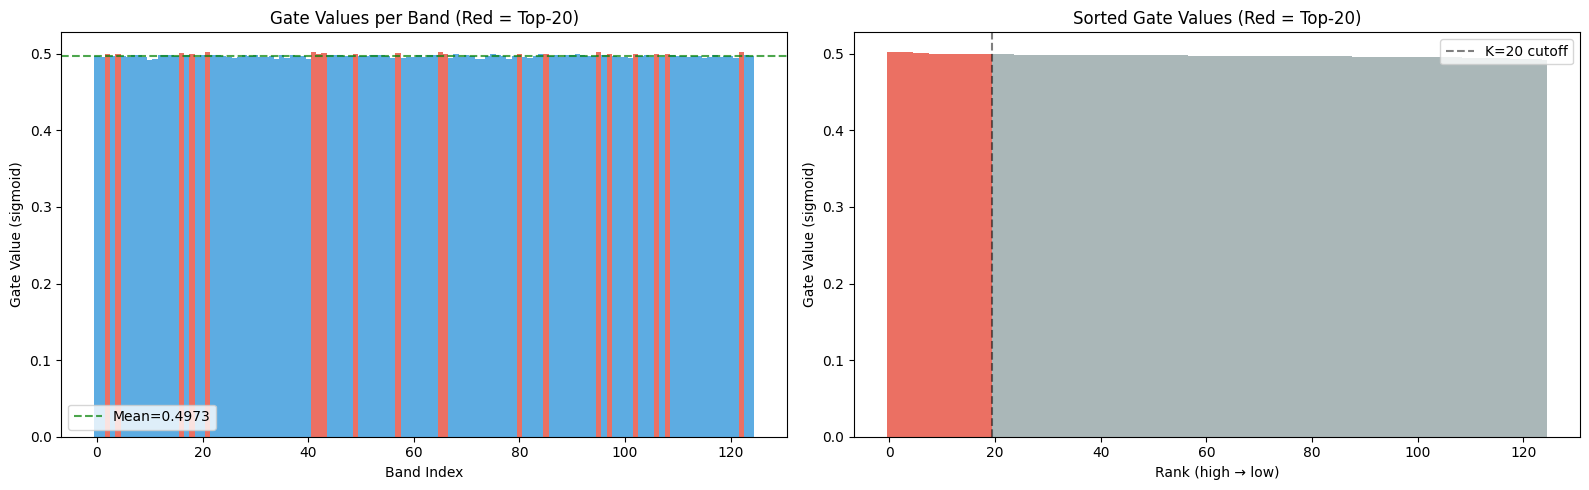


📊 Plot saved to D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\gate_analysis_topK.png


In [ ]:
import matplotlib.pyplot as plt

# ===== 1. Lấy gate values =====
with torch.no_grad():
    gate_vals = model.gate().detach().cpu().numpy()  # (125,)

K = 20  # Số band muốn chọn

# ===== 2. Sắp xếp theo gate value (cao → thấp) =====
sorted_idx = np.argsort(gate_vals)[::-1]  # descending
topK_idx = sorted_idx[:K]
topK_vals = gate_vals[topK_idx]
bottomK_idx = sorted_idx[-K:]

print(f"{'='*60}")
print(f"  GATE ANALYSIS  (Total bands = {len(gate_vals)}, K = {K})")
print(f"{'='*60}")
print(f"  Gate sum   : {gate_vals.sum():.2f}")
print(f"  Gate mean  : {gate_vals.mean():.4f}")
print(f"  Gate std   : {gate_vals.std():.4f}")
print(f"  Gate min   : {gate_vals.min():.4f}  (band {gate_vals.argmin()})")
print(f"  Gate max   : {gate_vals.max():.4f}  (band {gate_vals.argmax()})")
print(f"{'='*60}")
print(f"\n  TOP-{K} BANDS (highest gate values):")
print(f"  {'Band':>6s}  {'Gate Value':>12s}")
print(f"  {'-'*20}")
for i, (band, val) in enumerate(zip(topK_idx, topK_vals)):
    print(f"  {band:>6d}  {val:>12.6f}")

print(f"\n  Top-{K} band indices (sorted): {sorted(topK_idx.tolist())}")

# ===== 3. Visualize =====
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# (a) Bar chart - all 125 bands
ax1 = axes[0]
colors = ['#e74c3c' if i in topK_idx else '#3498db' for i in range(len(gate_vals))]
ax1.bar(range(len(gate_vals)), gate_vals, color=colors, alpha=0.8, width=1.0)
ax1.set_xlabel("Band Index")
ax1.set_ylabel("Gate Value (sigmoid)")
ax1.set_title(f"Gate Values per Band (Red = Top-{K})")
ax1.axhline(y=gate_vals.mean(), color='green', linestyle='--', alpha=0.7, label=f'Mean={gate_vals.mean():.4f}')
ax1.legend()

# (b) Sorted gate values
ax2 = axes[1]
sorted_vals = gate_vals[sorted_idx]
colors_sorted = ['#e74c3c' if i < K else '#95a5a6' for i in range(len(sorted_vals))]
ax2.bar(range(len(sorted_vals)), sorted_vals, color=colors_sorted, alpha=0.8, width=1.0)
ax2.set_xlabel("Rank (high → low)")
ax2.set_ylabel("Gate Value (sigmoid)")
ax2.set_title(f"Sorted Gate Values (Red = Top-{K})")
ax2.axvline(x=K-0.5, color='black', linestyle='--', alpha=0.5, label=f'K={K} cutoff')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, "gate_analysis_topK.png"), dpi=150, bbox_inches='tight')
plt.show()
print(f"\n📊 Plot saved to {os.path.join(CHECKPOINT_DIR, 'gate_analysis_topK.png')}")

In [ ]:
import json

# ===== Lưu Top-K band info =====
topK_info = {
    "K": int(K),
    "topK_band_indices": sorted(topK_idx.tolist()),
    "topK_band_indices_by_importance": topK_idx.tolist(),
    "topK_gate_values": topK_vals.tolist(),
    "gate_stats": {
        "sum": float(gate_vals.sum()),
        "mean": float(gate_vals.mean()),
        "std": float(gate_vals.std()),
        "min": float(gate_vals.min()),
        "max": float(gate_vals.max()),
    },
    "all_gate_values": gate_vals.tolist(),
    "source_checkpoint": CKPT_PATH,
}

topK_info_path = os.path.join(CHECKPOINT_DIR, "topK_band_info.json")
with open(topK_info_path, "w") as f:
    json.dump(topK_info, f, indent=2)

print(f"✅ Top-{K} band info saved to: {topK_info_path}")
print(f"\n📌 Dùng bands này cho pipeline tiếp theo:")
print(f"   SELECTED_BANDS = {sorted(topK_idx.tolist())}")

# ===== Threshold-based selection (thay vì hard K) =====
thresholds = [0.3, 0.4, 0.45, 0.49, 0.495, 0.5]
print(f"\n{'Threshold':>10s} | {'#Bands > threshold':>20s}")
print("-" * 35)
for t in thresholds:
    n = (gate_vals > t).sum()
    print(f"{t:>10.3f} | {n:>20d}")

✅ Top-20 band info saved to: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\topK_band_info.json

📌 Dùng bands này cho pipeline tiếp theo:
   SELECTED_BANDS = [2, 4, 16, 18, 21, 41, 42, 43, 49, 57, 65, 66, 80, 85, 95, 97, 102, 106, 108, 122]

 Threshold |   #Bands > threshold
-----------------------------------
     0.300 |                  125
     0.400 |                  125
     0.450 |                  125
     0.490 |                  125
     0.495 |                  109
     0.500 |                    8


## ⚠️ Lưu ý về Gate Training

Nếu gate values đều gần **0.5** (std rất nhỏ), điều đó có nghĩa là gate chưa học được band nào quan trọng hơn. 

**Nguyên nhân thường gặp:**
1. **Train chưa đủ epoch** — cần train thêm (20-50 epochs)
2. **LAMBDA_K quá nhỏ** — tăng lên 0.1-0.5 để ép gate thưa hơn
3. **Learning rate cho gate quá nhỏ** — thử tách lr riêng cho gate (lr = 1e-2)

**Gợi ý cải thiện:**
```python
# Tách optimizer cho gate với lr cao hơn
optimizer = torch.optim.AdamW([
    {"params": other_params, "lr": 1e-4, "weight_decay": 0.1},
    {"params": gate_params,  "lr": 1e-2, "weight_decay": 0.0},  # lr cao hơn cho gate
])

# Tăng K penalty
LAMBDA_K = 0.5  # thay vì 0.05
```

---
# 🔬 Hard-Concrete / L0 Gate — Band Selection

## 1. Vấn đề với Sigmoid Gate đơn giản

Sigmoid gate ở trên có **vấn đề**: gradient của sigmoid rất phẳng ở vùng gần 0 và 1, nên:
- Gate khó **collapse về 0** (tắt band) hoặc **lên 1** (giữ band)
- Tất cả gate đều "kẹt" quanh 0.5 → **không phân biệt** band quan trọng / không quan trọng
- Penalty $(g_{sum} - K)^2$ ép **tổng** giảm nhưng mỗi gate giảm **đều nhau** (không thưa)

## 2. Hard-Concrete Distribution (Louizos et al., 2018)

> **Paper**: *"Learning Sparse Neural Networks through L0 Regularization"* — ICLR 2018

### Ý tưởng chính:
Thay vì `sigmoid(logit)` liên tục trong $(0, 1)$, Hard-Concrete tạo ra gate có thể **chính xác = 0** hoặc **chính xác = 1**.

### Công thức:

**Khi TRAIN** (stochastic — có noise để gradient chạy được):

$$u \sim \text{Uniform}(0, 1)$$
$$s = \sigma\left(\frac{\log u - \log(1-u) + \log\alpha}{\beta}\right) \quad \text{(Binary Concrete)}$$
$$\bar{s} = s \cdot (\zeta - \gamma) + \gamma \quad \text{(Stretch ra ngoài [0,1])}$$
$$z = \min(1, \max(0, \bar{s})) \quad \text{(Hard clamp)}$$

Trong đó:
- $\log\alpha$ : **learnable parameter** (1 per band) — quyết định band on/off
- $\beta = 2/3$ : temperature (cố định)
- $\gamma = -0.1, \zeta = 1.1$ : stretch interval → cho phép $\bar{s}$ rơi ngoài $[0,1]$ → **clamp tạo exact 0/1**

**Khi EVAL** (deterministic — không sample):

$$z = \min\left(1, \max\left(0, \sigma(\log\alpha) \cdot (\zeta - \gamma) + \gamma\right)\right)$$

### L0 Regularization:

$$\mathcal{L}_{L0} = \sum_{i=1}^{C} \sigma\left(\log\alpha_i - \beta \cdot \log\frac{-\gamma}{\zeta}\right)$$

Đây là **xác suất band $i$ được bật** ($P(z_i \neq 0)$). Minimize L0 = ép nhiều band tắt.

### Loss tổng:

$$\mathcal{L} = \mathcal{L}_{CE} + \lambda_{L0} \cdot \mathcal{L}_{L0}$$

## 3. Tại sao tốt hơn Sigmoid Gate?

| | Sigmoid Gate | Hard-Concrete |
|---|---|---|
| Gate values | Liên tục $(0, 1)$, khó = 0 | Có thể **chính xác = 0 hoặc 1** |
| Sparsity | Ép bằng penalty gián tiếp | L0 penalty = đếm #bands bật |
| Gradient | Vanishing ở 0 và 1 | Reparameterization trick → gradient ok |
| Kết quả | Gate đều ~0.25, không phân biệt | Gate rõ ràng: 0 (tắt) vs 1 (bật) |

In [ ]:
# import torch
# import numpy as np
# from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

# @torch.no_grad()
# def get_preds_labels(model, loader, device):
#     model.eval()
#     all_preds, all_labels = [], []
#     for x, y in loader:
#         x = x.to(device)
#         y = y.to(device)
#         logits = model(x)
#         preds = torch.argmax(logits, dim=1)
#         all_preds.append(preds.detach().cpu().numpy())
#         all_labels.append(y.detach().cpu().numpy())
#     all_preds = np.concatenate(all_preds)
#     all_labels = np.concatenate(all_labels)
#     return all_preds, all_labels

# # 1) Lấy dự đoán + nhãn thật
# preds, labels = get_preds_labels(model, val_loader, device)

# # 2) Accuracy + F1
# acc = accuracy_score(labels, preds)
# f1_macro = f1_score(labels, preds, average="macro")
# f1_weighted = f1_score(labels, preds, average="weighted")

# print(f"Accuracy:     {acc:.4f}")
# print(f"F1-macro:     {f1_macro:.4f}")
# print(f"F1-weighted:  {f1_weighted:.4f}")

# # 3) Confusion matrix
# cm = confusion_matrix(labels, preds)
# print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)

# # 4) Report theo từng lớp
# # Nếu bạn có mapping idx_to_class thì in tên lớp cho đẹp
# if hasattr(val_loader.dataset, "idx_to_class"):
#     target_names = [val_loader.dataset.idx_to_class[i] for i in range(len(val_loader.dataset.idx_to_class))]
#     print("\nClassification Report:\n")
#     print(classification_report(labels, preds, target_names=target_names, digits=4))
# else:
#     print("\nClassification Report:\n")
#     print(classification_report(labels, preds, digits=4))


In [ ]:
# import matplotlib.pyplot as plt

# def plot_confusion_matrix(cm, class_names=None, title="Confusion Matrix"):
#     plt.figure(figsize=(6, 5))
#     plt.imshow(cm, interpolation="nearest")
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(cm))
#     if class_names is None:
#         class_names = [str(i) for i in range(len(cm))]
#     plt.xticks(tick_marks, class_names, rotation=45, ha="right")
#     plt.yticks(tick_marks, class_names)

#     thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             plt.text(j, i, format(cm[i, j], "d"),
#                      ha="center", va="center",
#                      color="white" if cm[i, j] > thresh else "black")

#     plt.ylabel("True label")
#     plt.xlabel("Predicted label")
#     plt.tight_layout()
#     plt.show()

# class_names = None
# if hasattr(val_loader.dataset, "idx_to_class"):
#     class_names = [val_loader.dataset.idx_to_class[i] for i in range(len(val_loader.dataset.idx_to_class))]

# plot_confusion_matrix(cm, class_names=class_names, title="Val Confusion Matrix")


In [ ]:
# class HSTestDataset(Dataset):
#     """
#     Test dataset — pipeline PHẢI khớp HSDataset (trừ augment & label):
#     load → ensure_chw → fix_bands → resize → clip_per_band → z-score
#     """
#     def __init__(self, img_dir, target_bands=125, target_hw=(64, 64), mean=None, std=None):
#         self.img_dir = img_dir
#         self.target_bands = target_bands
#         self.target_hw = target_hw
#         self.mean = (torch.tensor(mean).view(target_bands, 1, 1).float()
#                      if mean is not None else torch.zeros(target_bands, 1, 1))
#         self.std  = (torch.tensor(std).view(target_bands, 1, 1).float()
#                      if std is not None else torch.ones(target_bands, 1, 1))
#         self.files = sorted([f for f in os.listdir(img_dir)
#                              if f.lower().endswith(('.tif', '.tiff'))])

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, idx):
#         fname = self.files[idx]
#         path  = os.path.join(self.img_dir, fname)

#         # 1. Load
#         arr = tiff.imread(path).astype(np.float32)

#         # 2. Ensure CHW  (cùng hàm với train)
#         arr = ensure_chw(arr, self.target_bands)

#         # 3. Fix bands  (pad spatial-mean, KHÔNG pad 0)
#         arr = fix_bands(arr, self.target_bands)

#         x = torch.from_numpy(arr)  # (C, H, W)

#         # 4. Resize
#         if x.shape[1:] != self.target_hw:
#             x = F.interpolate(x.unsqueeze(0), size=self.target_hw,
#                               mode="bilinear", align_corners=False).squeeze(0)

#         # 5. Clip per-band  (TRƯỚC ĐÂY BỊ THIẾU → khiến z-score sai)
#         x = clip_per_band(x, 0.01, 0.99)

#         # 6. Z-score normalize
#         x = (x - self.mean) / (self.std + 1e-8)

#         return x, fname


# if os.path.exists(TEST_HS_DIR):
#     # Load best checkpoint for test prediction
#     model.load_state_dict(torch.load(CKPT_PATH, map_location=device, weights_only=True))
#     model = model.to(device)
#     model.eval()
#     print(f"Loaded checkpoint: {CKPT_PATH}")
#     print(f"Model on device: {next(model.parameters()).device}")

#     test_ds = HSTestDataset(TEST_HS_DIR, TARGET_BANDS, TARGET_HW,
#                             mean=mean_stats, std=std_stats)
#     test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

#     preds = []
#     ids = []
#     class_names = [train_ds.idx_to_class[i] for i in range(num_classes)]

#     with torch.no_grad():
#         for x, fname in tqdm(test_loader, desc="Predicting"):
#             x = x.to(device)
#             out = model(x)
#             p_idx = out.argmax(1).cpu().numpy()
#             preds.extend([class_names[i] for i in p_idx])
#             ids.extend(fname)

#     import pandas as pd

#     df = pd.DataFrame({"Id": ids, "Category": preds})

#     df.to_csv(os.path.join(CHECKPOINT_DIR, "submission_hs.csv"), index=False)    
#     print("Saved submission_hs.csv")